In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from collections import Counter
import string
import re
import argparse
import json
import sys

In [2]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)

In [3]:
def identify_question_type(question):
    if 'what' in question:
        return 'what'
    elif 'who' in question:
        return 'who'
    elif 'how' in question:
        return 'how'
    elif 'when' in question:
        return 'when'
    elif 'which' in question:
        return 'which'
    elif 'where' in question:
        return 'where'
    elif 'why' in question:
        return 'why'
    else:
        return 'other'

In [4]:
with open('../predictions.json') as f:
    predictions = json.load(f)
    
with open('../data/dev-v1.1.json') as f:
    dataset_json = json.load(f)
    dataset = dataset_json['data']

In [5]:
question_type_list = []
context_len_list = []
query_len_list = []
avg_answer_len_list = []
tmp_exact_match_list = []
tmp_f1_list = []

err_context = []
err_question = []
err_ground_truth = []
err_prediction = []
err_em = []


f1 = exact_match = total = 0
for article in dataset:
    for paragraph in article['paragraphs']:
        for qa in paragraph['qas']:
            total += 1
            if qa['id'] not in predictions:
                message = 'Unanswered question ' + qa['id'] + \
                          ' will receive score 0.'
                print(message, file=sys.stderr)
                continue
            ground_truths = list(map(lambda x: x['text'], qa['answers']))
            prediction = predictions[qa['id']]
            question = qa['question']
            
            question_type = identify_question_type(normalize_answer(question))
            context_len = len(normalize_answer(paragraph['context']).split())
            query_len = len(normalize_answer(qa['question']).split())
            avg_answer_len = sum([len(normalize_answer(item).split()) for item in ground_truths]) / len(ground_truths)
            
            tmp_exact_match = metric_max_over_ground_truths(
                exact_match_score, prediction, ground_truths)
            tmp_f1 = metric_max_over_ground_truths(
                f1_score, prediction, ground_truths)
            
            question_type_list.append(question_type)
            context_len_list.append(context_len)
            query_len_list.append(query_len)
            avg_answer_len_list.append(avg_answer_len)
            tmp_exact_match_list.append(tmp_exact_match)
            tmp_f1_list.append(tmp_f1)
            
            err_context.append(paragraph)
            err_question.append(question)
            err_ground_truth.append(ground_truths)
            err_prediction.append(prediction)
            err_em.append(tmp_exact_match)
            
            exact_match += metric_max_over_ground_truths(
                exact_match_score, prediction, ground_truths)
            f1 += metric_max_over_ground_truths(
                f1_score, prediction, ground_truths)

exact_match = 100.0 * exact_match / total
f1 = 100.0 * f1 / total

In [6]:
ground_truths

['sthène', 'sthène', 'sthène', 'sthène', 'sthène']

In [7]:
prediction

'kip'

In [8]:
question

'What is the seldom used force unit equal to one thousand newtons?'

In [9]:
question_type

'what'

In [10]:
len(question_type_list), len(context_len_list), len(query_len_list), len(avg_answer_len_list)

(10570, 10570, 10570, 10570)

In [11]:
df = pd.DataFrame({'question_type': question_type_list, 'context_len': context_len_list, 
                  'query_len': query_len_list, 'avg_answer_len': avg_answer_len_list, 
                  'exact_match': tmp_exact_match_list, 'f1': tmp_f1_list})

In [12]:
df.head()

,avg_answer_len,context_len,exact_match,f1,query_len,question_type
0,2.000000,109,False,0.25,9,which
1,2.000000,109,False,0.00,9,which
2,5.333333,109,True,1.00,7,where
3,2.000000,109,False,0.00,7,which
4,1.000000,109,False,0.00,11,what


In [13]:
context_length = pd.DataFrame(df.groupby('context_len')['f1'].apply(np.mean)).reset_index().sort_values('context_len', ascending=True)

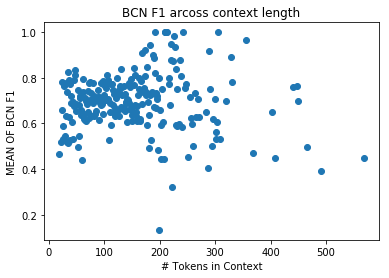

In [14]:
plt.plot(context_length['context_len'], context_length['f1'], 'o')
# plt.axis([0, 700, 0, 1.1])
plt.ylabel('MEAN OF BCN F1')
plt.xlabel('# Tokens in Context')
plt.title('BCN F1 arcoss context length')
plt.show()

In [15]:
query_length = pd.DataFrame(df.groupby('query_len')['f1'].apply(np.mean)).reset_index().sort_values('query_len', ascending=True)

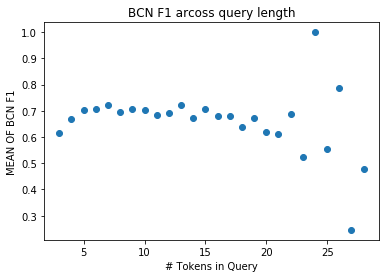

In [16]:
plt.plot(query_length['query_len'], query_length['f1'], 'o')
# plt.axis([0, 700, 0, 1.1])
plt.ylabel('MEAN OF BCN F1')
plt.xlabel('# Tokens in Query')
plt.title('BCN F1 arcoss query length')
plt.show()

In [17]:
avg_answer_length = pd.DataFrame(df.groupby('avg_answer_len')['f1'].apply(np.mean)).reset_index().sort_values('avg_answer_len', ascending=True)

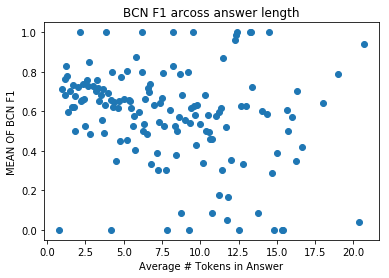

In [18]:
plt.plot(avg_answer_length['avg_answer_len'], avg_answer_length['f1'], 'o')
# plt.axis([0, 700, 0, 1.1])
plt.ylabel('MEAN OF BCN F1')
plt.xlabel('Average # Tokens in Answer')
plt.title('BCN F1 arcoss answer length')
plt.show()

In [19]:
performance_type = pd.DataFrame(df.groupby('question_type')['f1'].apply(np.mean)).reset_index().sort_values('question_type', ascending=False)

In [20]:
performance_type

,question_type,f1
7,why,0.518765
6,who,0.738607
5,which,0.733742
4,where,0.704233
3,when,0.844276
2,what,0.680141
1,other,0.450288
0,how,0.700183


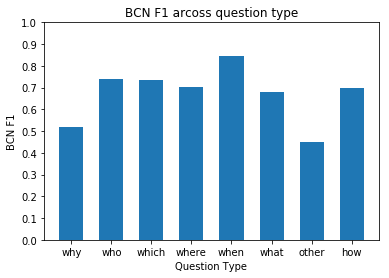

In [21]:
plt.bar(np.arange(8), performance_type['f1'], 0.6)

plt.xlabel('Question Type')
plt.ylabel('BCN F1')
plt.title('BCN F1 arcoss question type')
plt.xticks(np.arange(8), performance_type['question_type'])
plt.yticks(np.arange(0, 1.1, 0.1))
# plt.legend((p1[0], p2[0]), ('Men', 'Women'))
plt.show()

In [22]:
with open('../attn_file.txt') as f:
    for line in f:
        m = json.loads(line)
        break

In [23]:
m.keys()

dict_keys(['pred_end_batch', 'pred_start_batch', 'end_dist', 'qn_ids', 'context_ids', 'start_dist', 'attn_output'])

In [24]:
with open('../id2word.txt') as f:
    for line in f:
        id2word = json.loads(line)

In [25]:
id2word = {int(k): v for k, v in id2word.items()}

In [26]:
id2word[0]

'<pad>'

In [27]:
np.array(m['start_dist']).shape

(60, 400)

In [28]:
np.array(m['end_dist']).shape

(60, 400)

In [29]:
len(m['pred_start_batch']), len(m['pred_end_batch'])

(60, 60)

In [30]:
np.array(m['context_ids']).shape

(60, 400)

In [31]:
np.array(m['qn_ids']).shape

(60, 30)

In [32]:
np.array(m['attn_output']).shape

(60, 401, 31)

## 2nd case

In [43]:
c1st = np.array(m['context_ids'])[6, :].tolist()
q1st = np.array(m['qn_ids'])[6, :].tolist()
a1st = np.array(m['attn_output'])[6, :-1, :-1]

In [44]:
c1st = [id2word[i] for i in c1st]
q1st = [id2word[i] for i in q1st]

In [45]:
sd1st = np.array(m['start_dist'])[6, :]
ed1st = np.array(m['end_dist'])[6, :]

In [46]:
sp = m['pred_start_batch'][6]
ep = m['pred_end_batch'][6]

In [47]:
q1st.index('<pad>'), c1st.index('<pad>'), a1st.shape

(8, 147, (400, 30))

In [48]:
q1st[:8]

['what', 'day', 'was', 'the', 'game', 'played', 'on', '?']

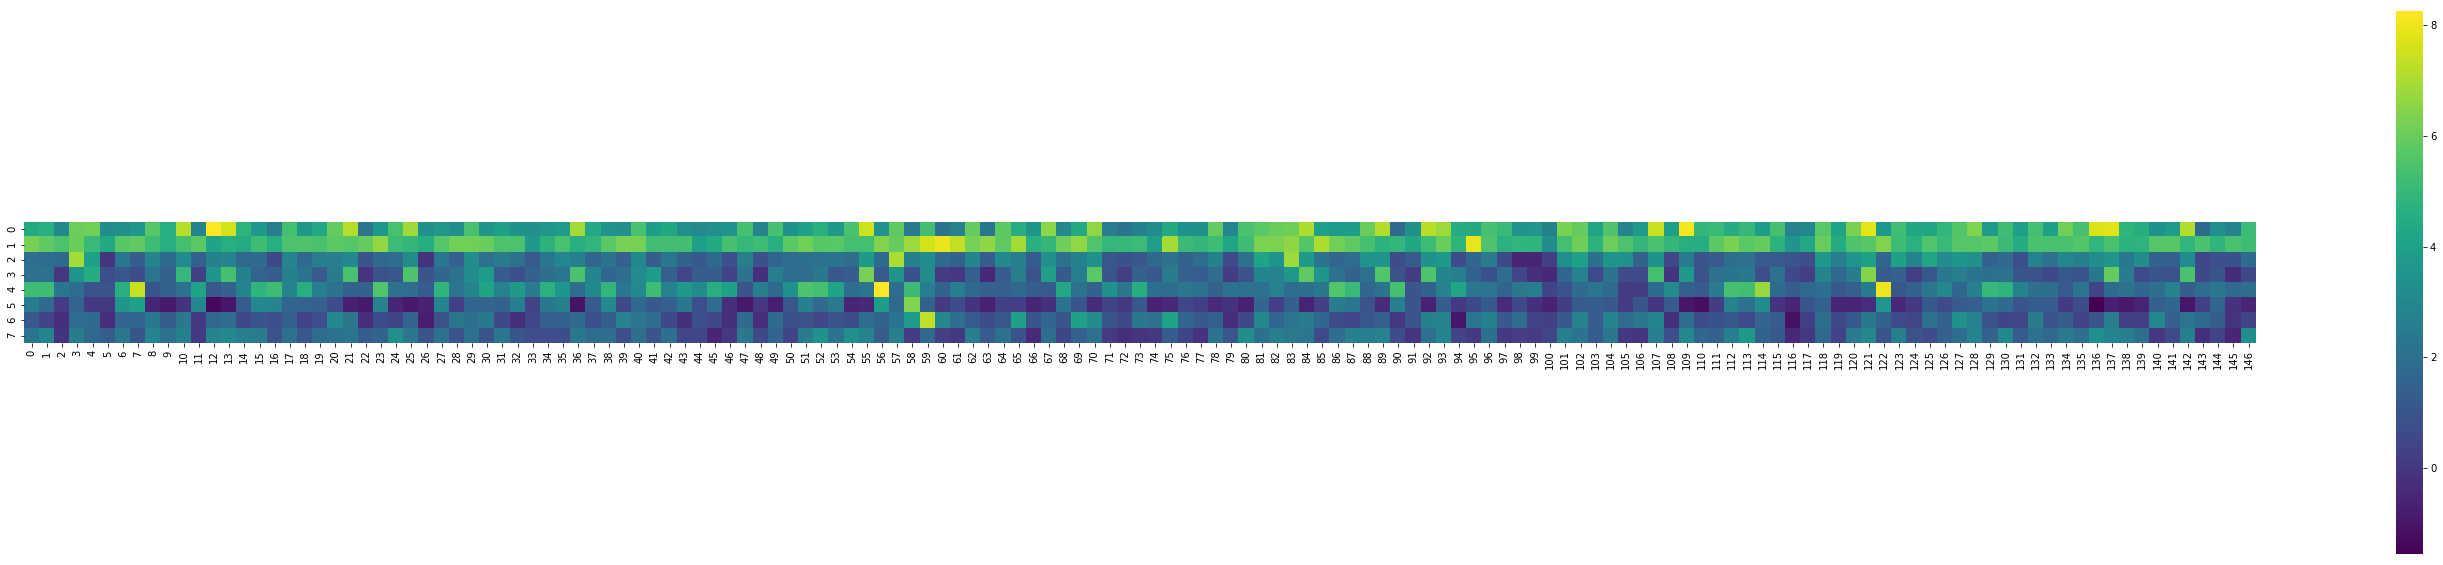

In [49]:
colormap = plt.cm.viridis
plt.figure(figsize=(50,10))
sns.heatmap(a1st.T[:8, :147],square=True, cmap=colormap, linecolor='white')
plt.show()

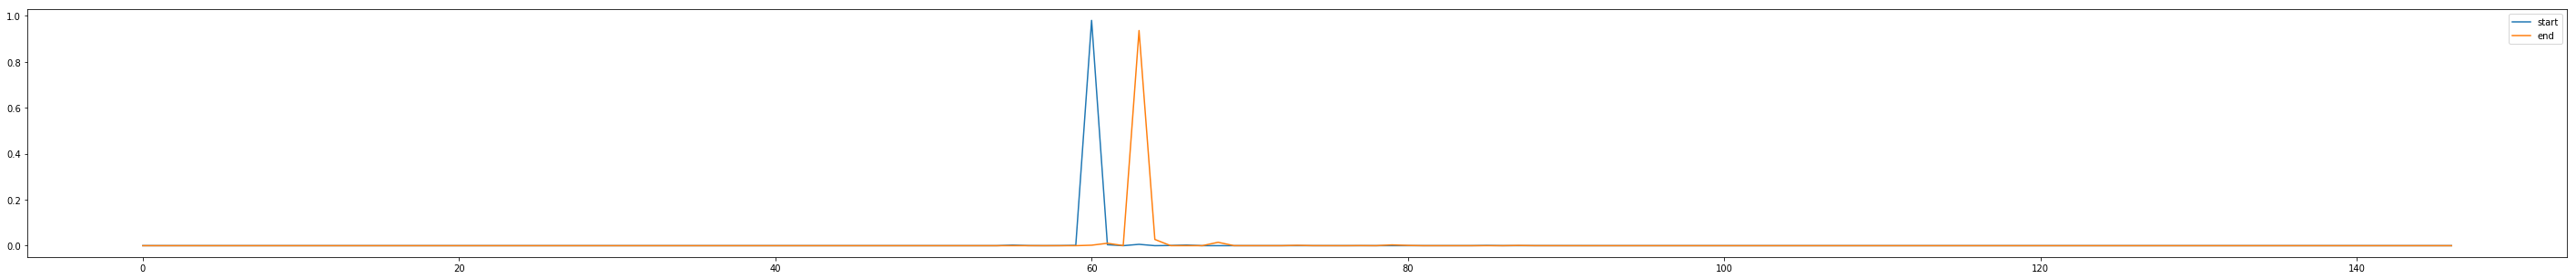

In [50]:
plt.figure(figsize=(50,5))
plt.plot(sd1st[:147], label='start')
plt.plot(ed1st[:147], label='end')
plt.legend(loc='upper right')

In [51]:
sp, ep

(60, 63)

In [52]:
c1st[60:63+1]

['february', '7', ',', '2016']

In [75]:
c1st[55:66]

['the', 'game', 'was', 'played', 'on', 'february', '7', ',', '2016', ',', 'at']

## 3rd case

In [63]:
c1st = np.array(m['context_ids'])[12, :].tolist()
q1st = np.array(m['qn_ids'])[12, :].tolist()
a1st = np.array(m['attn_output'])[12, :-1, :-1]

In [64]:
c1st = [id2word[i] for i in c1st]
q1st = [id2word[i] for i in q1st]

In [65]:
sd1st = np.array(m['start_dist'])[12, :]
ed1st = np.array(m['end_dist'])[12, :]

In [66]:
sp = m['pred_start_batch'][12]
ep = m['pred_end_batch'][12]

In [67]:
q1st.index('<pad>'), c1st.index('<pad>'), a1st.shape

(10, 147, (400, 30))

In [69]:
q1st[:10]

['what', 'venue', 'did', 'super', 'bowl', '50', 'take', 'place', 'in', '?']

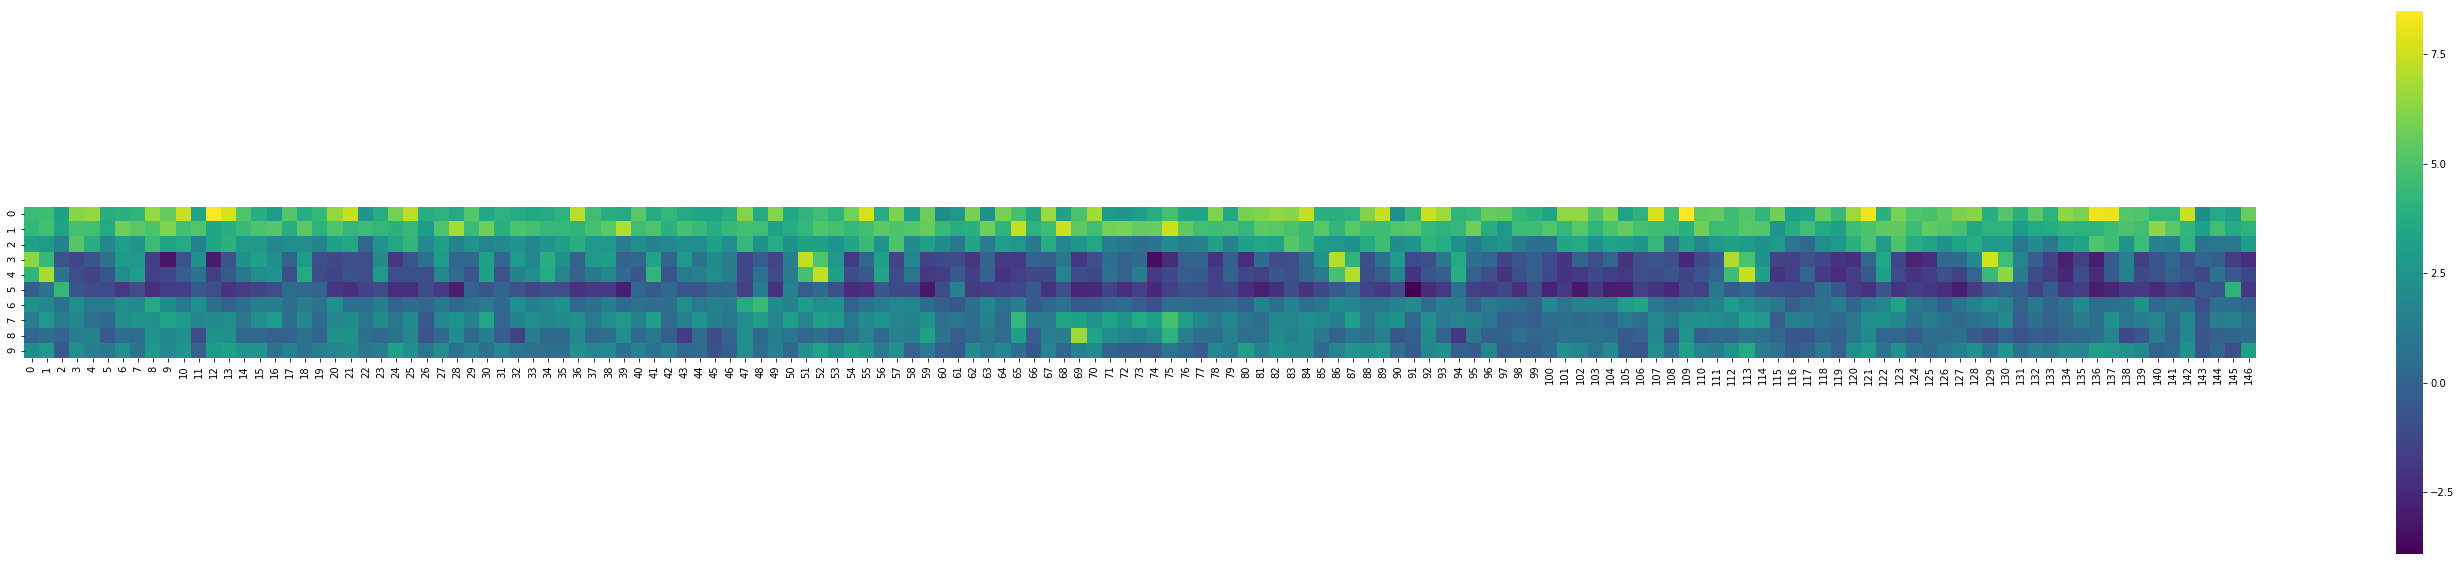

In [70]:
colormap = plt.cm.viridis
plt.figure(figsize=(50,10))
sns.heatmap(a1st.T[:10, :147],square=True, cmap=colormap, linecolor='white')
plt.show()

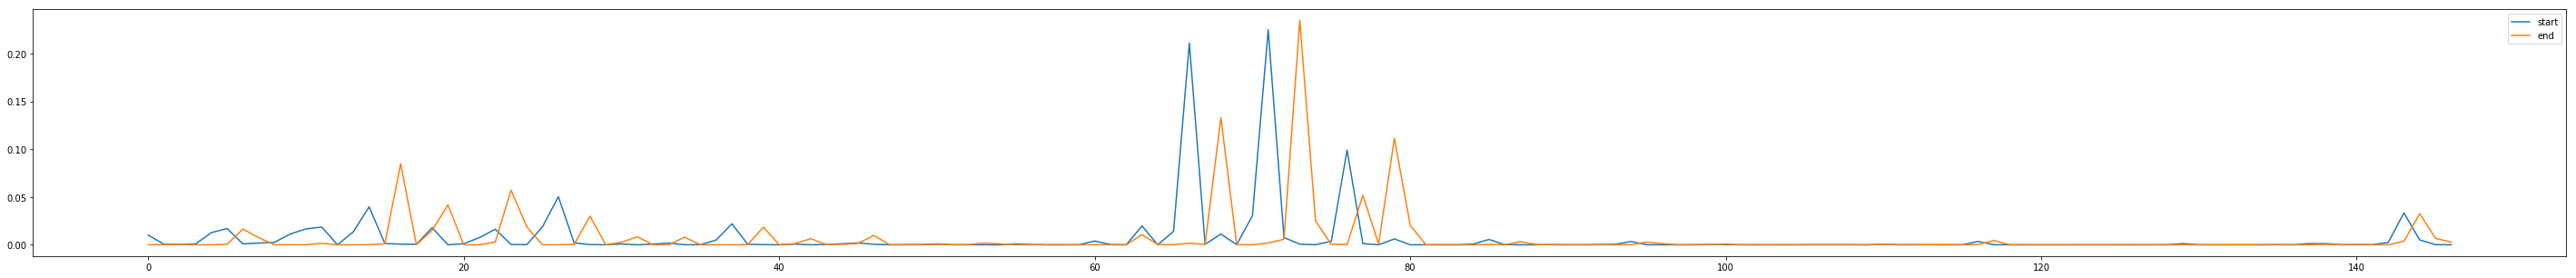

In [71]:
plt.figure(figsize=(50,5))
plt.plot(sd1st[:147], label='start')
plt.plot(ed1st[:147], label='end')
plt.legend(loc='upper right')

In [72]:
sp, ep

(71, 73)

In [73]:
c1st[71:73+1]

['san', 'francisco', 'bay']

In [76]:
c1st[65:81]

['at',
 'levi',
 "'s",
 'stadium',
 'in',
 'the',
 'san',
 'francisco',
 'bay',
 'area',
 'at',
 'santa',
 'clara',
 ',',
 'california',
 '.']